# Use simple techniques for feature Engineering and to do multi-class classification to predict review ratings based on the Amazon Reviews dataset

Objective for this exercise:
    * Establish NLP prediction accuracy baseline using simple ML models
    * Explore different permutation of feature engineering techniques, data, and classification algorithms
    * Compare accuracy of preduction using the following information:
        * Product Title
        * Review Headline
        * Review Body
    * (If time allows) see if using only helpful reviews to train improves our accuracy for our predictions - this reduces our 110k dataset to 35k


Feature Engineering Techniques:
    * bag of words
    * TF-IDF
    
    
Classification:
    * Logistic Regression Classification
    * K-nearest Neighbors Classification
    * Radius Neighbors Classification - document suggests the Radius Neighbors might be a better fit if our data is no uniform. From our exploratory data analysis, we see that most reviews skew towards 4 or 5 stars
    
    
    
    
Data used in this notebooks has already been pre-processed in the previous notebook. For details, please see: [amazon_review_preprocessing.ipynb](amazon_review_preprocessing.ipynb)

```
python preprocess_amazon.py -l INFO -r -o dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-smallout.csv dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-smallin.csv
```

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
import time


%matplotlib inline

In [2]:
# set global variables

# I'm finding that running these models on my laptop takes forever and they are not finishing so I'm going to start
# with a really small file just to validate my code
#
# datafile was generated from amazon_review_preprocessing.ipynb - this file has 1k reviews randomly chosen
# from original file
KEEP_COLUMNS = ["product_title", "helpful_votes", "review_headline", "review_body", "star_rating"]
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
OUTCOME_COLUMN = "star_rating"


# Configuration
DATA_FILE = "dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-tinyout.csv"
# NEIGHBORS = [5]
NEIGHBORS = [1, 3, 5, 7, 9, 11]

# Radius for RadiusNeighbor
# didn't try too many numbers but tried 1 and 3 and didn't find any neighbors
# RADII = [5.0]
RADII = [5.0, 7.0, 9.0, 11.0, 13.0]

# logistic regression settings
# C= [1.0]
C = [0.2, 0.4, 0.6, 0.8, 1.0]


FEATURE_COLUMN = "review_headline"
ENABLE_KNN = True
ENABLE_RN = True
ENABLE_LR = True
ENABLE_BOW = True
ENABLE_TFIDF = True



In [3]:
# read in DF
df = pd.read_csv(DATA_FILE)[KEEP_COLUMNS]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22414 entries, 0 to 22413
Data columns (total 5 columns):
product_title      22414 non-null object
helpful_votes      22414 non-null int64
review_headline    22414 non-null object
review_body        22414 non-null object
star_rating        22414 non-null int64
dtypes: int64(2), object(3)
memory usage: 875.6+ KB
None


,product_title,helpful_votes,review_headline,review_body,star_rating
0,tfy universal car headrest mount holder portab...,0,good enough,serves purpose loud whoever sitting seat attached,3
1,iccker art nylon hair paint brush tools set bl...,0,five stars,works really well samsung s6 otterbox defender...,5
2,jbl gx series coaxial car loudspeakers certifi...,1,speakers did not sound well thought,speakers did not sound well thought would jbls...,2
3,otium screen protectors,0,really easy install included guide,absoultely perfect included install guide make...,5
4,apple watch stand vtin aluminum alloy build ho...,0,love,heres lot like stand apple watch very modern s...,5


In [4]:
# let's get some data on our text

def wc(x:str):
    return len(str(x).split())

df["pt_wc"] = df.product_title.apply(wc)
df["rh_wc"] = df.review_headline.apply(wc)
df["rb_wc"] = df.review_body.apply(wc)
df.describe()

,helpful_votes,star_rating,pt_wc,rh_wc,rb_wc
count,22414.000000,22414.000000,22414.000000,22414.000000,22414.000000
mean,0.904792,3.895333,15.907335,2.956322,25.979700
std,8.709008,1.465474,9.716846,1.915684,41.441713
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,3.000000,9.000000,2.000000,8.000000
50%,0.000000,5.000000,14.000000,2.000000,15.000000
75%,0.000000,5.000000,20.000000,4.000000,28.000000
max,868.000000,5.000000,92.000000,21.000000,1133.000000


In [5]:
# Set up different dataframes for training

# outcome
Y = df["star_rating"]
X = df[FEATURE_COLUMN]

### Define a function to help us run models

In [6]:
def run_model(model, X_train, Y_train, X_test, Y_test):
        """
        model: model to train with
        X_test: training input
        Y_train: training classes
        X_test: test input
        Y_test: result
        -----
        return dictionary with train time, score time, total time, score
        """

        train_time_start = datetime.now()
        print(f'Start training: {train_time_start.strftime(TIME_FORMAT)}')
        result = model.fit(bag_X_train, bag_Y_train)

        train_time_end = datetime.now()
        print(f'End training: {train_time_end.strftime(TIME_FORMAT)}')

        score = result.score(bag_X_test, bag_Y_test)

        score_time_end = datetime.now()
        print(f'End Scoring: {score_time_end.strftime(TIME_FORMAT)}')

        train_time = train_time_end - train_time_start
        train_time_min = round(train_time.total_seconds() / 60)
        print(f'Training time (min): {train_time_min}')


        score_time = score_time_end - train_time_end
        score_time_min = round(score_time.total_seconds() / 60)
        print(f'Scoring time (min): {score_time_min}')

        print(f'Training score: {score}')

        return {
                "train_time_min": train_time_min,
                "score_time_min": score_time_min,
                "total_time_min": train_time_min + score_time_min,
                "score": score
               }



# Bag of Words

In [7]:
# TODO: try different parameters for CountVectorizers?
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(X.array)
vocab = cv.get_feature_names()
# print(f"vocab: {vocab}")
bag_pd = pd.DataFrame(cv_matrix.toarray(), columns=vocab)

In [8]:
# explore the data
print(len(vocab))
bag_pd.head()

5646


,00,000,02,03,04,05,06,07,09,0s,...,zero,zerolemon,zgreat,zip,zippers,zone,zoom,zr,zte,zune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# split results into training and test set
bag_X_train, bag_X_test, bag_Y_train, bag_Y_test = train_test_split(bag_pd, Y, random_state=1)

print(f"training set size {len(bag_X_train)}")
print(f"test set size {len(bag_X_test)}")

training set size 16810
test set size 5604


### Bag of Words Using KNN

In [10]:
# use K-nearest neighbors to train
knn_results_pd = pd.DataFrame(columns=["neighbors", "train_time_min", "score_time_min", "total_time_min", "score"])

if ENABLE_KNN and ENABLE_BOW:

    for neighbor in NEIGHBORS:
        print(f'{neighbor} neighbors\n-----------------------')
        neigh = KNeighborsClassifier(n_neighbors=neighbor, n_jobs=-1)
        results = run_model(neigh, bag_X_train, bag_Y_train, bag_X_test, bag_Y_test)
        results["neighbors"] = neighbor
        knn_results_pd = knn_results_pd.append(results, ignore_index=True)

knn_results_pd.head()
        


1 neighbors
-----------------------
Start training: 2019-05-16 02:34:37
End training: 2019-05-16 02:34:44
End Scoring: 2019-05-16 02:36:31
Training time (min): 0
Scoring time (min): 2
Training score: 0.6097430406852249
3 neighbors
-----------------------
Start training: 2019-05-16 02:36:31
End training: 2019-05-16 02:36:38
End Scoring: 2019-05-16 02:38:50
Training time (min): 0
Scoring time (min): 2
Training score: 0.6325838686652391
5 neighbors
-----------------------
Start training: 2019-05-16 02:38:50
End training: 2019-05-16 02:38:56
End Scoring: 2019-05-16 02:41:17
Training time (min): 0
Scoring time (min): 2
Training score: 0.6598857958600999
7 neighbors
-----------------------
Start training: 2019-05-16 02:41:17
End training: 2019-05-16 02:41:23
End Scoring: 2019-05-16 02:43:47
Training time (min): 0
Scoring time (min): 2
Training score: 0.6721984296930764
9 neighbors
-----------------------
Start training: 2019-05-16 02:43:47
End training: 2019-05-16 02:43:54
End Scoring: 2019-

,neighbors,train_time_min,score_time_min,total_time_min,score
0,1.0,0.0,2.0,2.0,0.609743
1,3.0,0.0,2.0,2.0,0.632584
2,5.0,0.0,2.0,2.0,0.659886
3,7.0,0.0,2.0,2.0,0.672198
4,9.0,0.0,3.0,3.0,0.682905


### Bag of Words using Radius Neighbors Classifier

Documentation says if the data is not evenly distributed Radius Neighbors might be a better algorithm so trying that here

In [11]:
rn_results_pd = pd.DataFrame()

if ENABLE_RN and ENABLE_BOW:
    for radius in RADII:
        rnc = RadiusNeighborsClassifier(radius=radius, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(rnc, bag_X_train, bag_Y_train, bag_X_test, bag_Y_test)
        results["radius"] = radius
        rn_results_pd = rn_results_pd.append(results, ignore_index=True)

rn_results_pd.head()


Radius: 5.0
-----------------------
Start training: 2019-05-16 02:49:03
End training: 2019-05-16 02:49:09
End Scoring: 2019-05-16 02:52:27
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 7.0
-----------------------
Start training: 2019-05-16 02:52:27
End training: 2019-05-16 02:52:34
End Scoring: 2019-05-16 02:55:50
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 9.0
-----------------------
Start training: 2019-05-16 02:55:50
End training: 2019-05-16 02:55:56
End Scoring: 2019-05-16 02:59:15
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 11.0
-----------------------
Start training: 2019-05-16 02:59:15
End training: 2019-05-16 02:59:21
End Scoring: 2019-05-16 03:02:20
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 13.0
-----------------------
Start training: 2019-05-16 03:02:21
End training: 2019-05-16 03:02:27
End Scoring: 2019-05

,radius,score,score_time_min,total_time_min,train_time_min
0,5.0,0.543719,3.0,3.0,0.0
1,7.0,0.543719,3.0,3.0,0.0
2,9.0,0.543719,3.0,3.0,0.0
3,11.0,0.543719,3.0,3.0,0.0
4,13.0,0.543719,3.0,3.0,0.0


### Bag of Word using Logistic Regression - what parameters should I play with here?

In [12]:
lr_results_pd = pd.DataFrame()

if ENABLE_LR and ENABLE_BOW:
    for c in C:
        lr = LogisticRegression(random_state=0, solver='lbfgs',
                                  multi_class='auto',
                                max_iter=1000, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(lr, bag_X_train, bag_Y_train, bag_X_test, bag_Y_test)
        results["c"] = c
        lr_results_pd = lr_results_pd.append(results, ignore_index=True)

lr_results_pd.head()


Radius: 13.0
-----------------------
Start training: 2019-05-16 03:04:59
End training: 2019-05-16 03:09:06
End Scoring: 2019-05-16 03:09:06
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Radius: 13.0
-----------------------
Start training: 2019-05-16 03:09:06
End training: 2019-05-16 03:13:13
End Scoring: 2019-05-16 03:13:13
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Radius: 13.0
-----------------------
Start training: 2019-05-16 03:13:13
End training: 2019-05-16 03:17:16
End Scoring: 2019-05-16 03:17:16
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Radius: 13.0
-----------------------
Start training: 2019-05-16 03:17:16
End training: 2019-05-16 03:21:24
End Scoring: 2019-05-16 03:21:24
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Radius: 13.0
-----------------------
Start training: 2019-05-16 03:21:24
End training: 2019-05-16 03:25:31
End Scoring: 

,c,score,score_time_min,total_time_min,train_time_min
0,0.2,0.705924,0.0,4.0,4.0
1,0.4,0.705924,0.0,4.0,4.0
2,0.6,0.705924,0.0,4.0,4.0
3,0.8,0.705924,0.0,4.0,4.0
4,1.0,0.705924,0.0,4.0,4.0


# TD-IDF

In [13]:
# TODO: play with min_df and max_df
# TODO: play with variations of ngram
tv = TfidfVectorizer(min_df=0., max_df=1., ngram_range=(1,3), use_idf=True)
tv_matrix = tv.fit_transform(X.array)
vocab = tv.get_feature_names()
tv_pd = pd.DataFrame(np.round(tv_matrix.toarray(), 2), columns=vocab)

In [14]:
# split results into training and test set
tv_X_train, tv_X_test, tv_Y_train, tv_Y_test = train_test_split(tv_pd, Y, random_state=1)

print(f"training set size {len(tv_X_train)}")
print(f"test set size {len(tv_X_test)}")

training set size 16810
test set size 5604


### KNN

In [15]:
# use K-nearest neighbors to train
knn_tv_results_pd = pd.DataFrame(columns=["neighbors", "train_time_min", "score_time_min", "total_time_min", "score"])

if ENABLE_KNN and ENABLE_TFIDF:

    for neighbor in NEIGHBORS:
        print(f'{neighbor} neighbors\n-----------------------')
        neigh = KNeighborsClassifier(n_neighbors=neighbor, n_jobs=-1)
        results = run_model(neigh, tv_X_train, tv_Y_train, tv_X_test, tv_Y_test)
        results["neighbors"] = neighbor
        knn_tv_results_pd = knn_tv_results_pd.append(results, ignore_index=True)

knn_tv_results_pd.head()
        


1 neighbors
-----------------------
Start training: 2019-05-16 03:26:12
End training: 2019-05-16 03:26:19
End Scoring: 2019-05-16 03:28:09
Training time (min): 0
Scoring time (min): 2
Training score: 0.6097430406852249
3 neighbors
-----------------------
Start training: 2019-05-16 03:28:09
End training: 2019-05-16 03:28:15
End Scoring: 2019-05-16 03:30:24
Training time (min): 0
Scoring time (min): 2
Training score: 0.6325838686652391
5 neighbors
-----------------------
Start training: 2019-05-16 03:30:24
End training: 2019-05-16 03:30:31
End Scoring: 2019-05-16 03:32:47
Training time (min): 0
Scoring time (min): 2
Training score: 0.6598857958600999
7 neighbors
-----------------------
Start training: 2019-05-16 03:32:47
End training: 2019-05-16 03:32:53
End Scoring: 2019-05-16 03:35:16
Training time (min): 0
Scoring time (min): 2
Training score: 0.6721984296930764
9 neighbors
-----------------------
Start training: 2019-05-16 03:35:16
End training: 2019-05-16 03:35:23
End Scoring: 2019-

,neighbors,train_time_min,score_time_min,total_time_min,score
0,1.0,0.0,2.0,2.0,0.609743
1,3.0,0.0,2.0,2.0,0.632584
2,5.0,0.0,2.0,2.0,0.659886
3,7.0,0.0,2.0,2.0,0.672198
4,9.0,0.0,2.0,2.0,0.682905


### Radius Neighbor Classifier

In [16]:
rn_tv_results_pd = pd.DataFrame()

if ENABLE_RN and ENABLE_TFIDF:
    for radius in RADII:
        rnc = RadiusNeighborsClassifier(radius=radius, n_jobs=-1)
        print(f'Radius: {radius}\n-----------------------')
        results = run_model(rnc, tv_X_train, tv_Y_train, tv_X_test, tv_Y_test)
        results["radius"] = radius
        rn_tv_results_pd = rn_tv_results_pd.append(results, ignore_index=True)

rn_tv_results_pd.head()


Radius: 5.0
-----------------------
Start training: 2019-05-16 03:40:27
End training: 2019-05-16 03:40:34
End Scoring: 2019-05-16 03:43:51
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 7.0
-----------------------
Start training: 2019-05-16 03:43:51
End training: 2019-05-16 03:43:58
End Scoring: 2019-05-16 03:47:14
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 9.0
-----------------------
Start training: 2019-05-16 03:47:14
End training: 2019-05-16 03:47:20
End Scoring: 2019-05-16 03:50:36
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 11.0
-----------------------
Start training: 2019-05-16 03:50:36
End training: 2019-05-16 03:50:42
End Scoring: 2019-05-16 03:53:38
Training time (min): 0
Scoring time (min): 3
Training score: 0.543718772305496
Radius: 13.0
-----------------------
Start training: 2019-05-16 03:53:38
End training: 2019-05-16 03:53:45
End Scoring: 2019-05

,radius,score,score_time_min,total_time_min,train_time_min
0,5.0,0.543719,3.0,3.0,0.0
1,7.0,0.543719,3.0,3.0,0.0
2,9.0,0.543719,3.0,3.0,0.0
3,11.0,0.543719,3.0,3.0,0.0
4,13.0,0.543719,2.0,2.0,0.0


### Logistic Regression Classifier

In [17]:
lr_tv_results_pd = pd.DataFrame()

if ENABLE_LR and ENABLE_TFIDF:
    for c in C:
        lr = LogisticRegression(random_state=0, solver='lbfgs',
                                  multi_class='auto',
                                max_iter=1000, n_jobs=-1)
        print(f'Regularization: {c}\n-----------------------')
        results = run_model(lr, tv_X_train, tv_Y_train, tv_X_test, tv_Y_test)
        results["c"] = c
        lr_tv_results_pd = lr_tv_results_pd.append(results, ignore_index=True)

lr_tv_results_pd.head()


Regularization: 0.2
-----------------------
Start training: 2019-05-16 03:56:14
End training: 2019-05-16 04:00:28
End Scoring: 2019-05-16 04:00:28
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Regularization: 0.4
-----------------------
Start training: 2019-05-16 04:00:28
End training: 2019-05-16 04:04:44
End Scoring: 2019-05-16 04:04:44
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Regularization: 0.6
-----------------------
Start training: 2019-05-16 04:04:44
End training: 2019-05-16 04:09:02
End Scoring: 2019-05-16 04:09:02
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Regularization: 0.8
-----------------------
Start training: 2019-05-16 04:09:02
End training: 2019-05-16 04:13:12
End Scoring: 2019-05-16 04:13:13
Training time (min): 4
Scoring time (min): 0
Training score: 0.7059243397573162
Regularization: 1.0
-----------------------
Start training: 2019-05-16 04:13:13
End training

,c,score,score_time_min,total_time_min,train_time_min
0,0.2,0.705924,0.0,4.0,4.0
1,0.4,0.705924,0.0,4.0,4.0
2,0.6,0.705924,0.0,4.0,4.0
3,0.8,0.705924,0.0,4.0,4.0
4,1.0,0.705924,0.0,4.0,4.0


# Data Visualization For Our Results

Text(0.5, 1.0, 'Logistic TFIDF Regression Score')

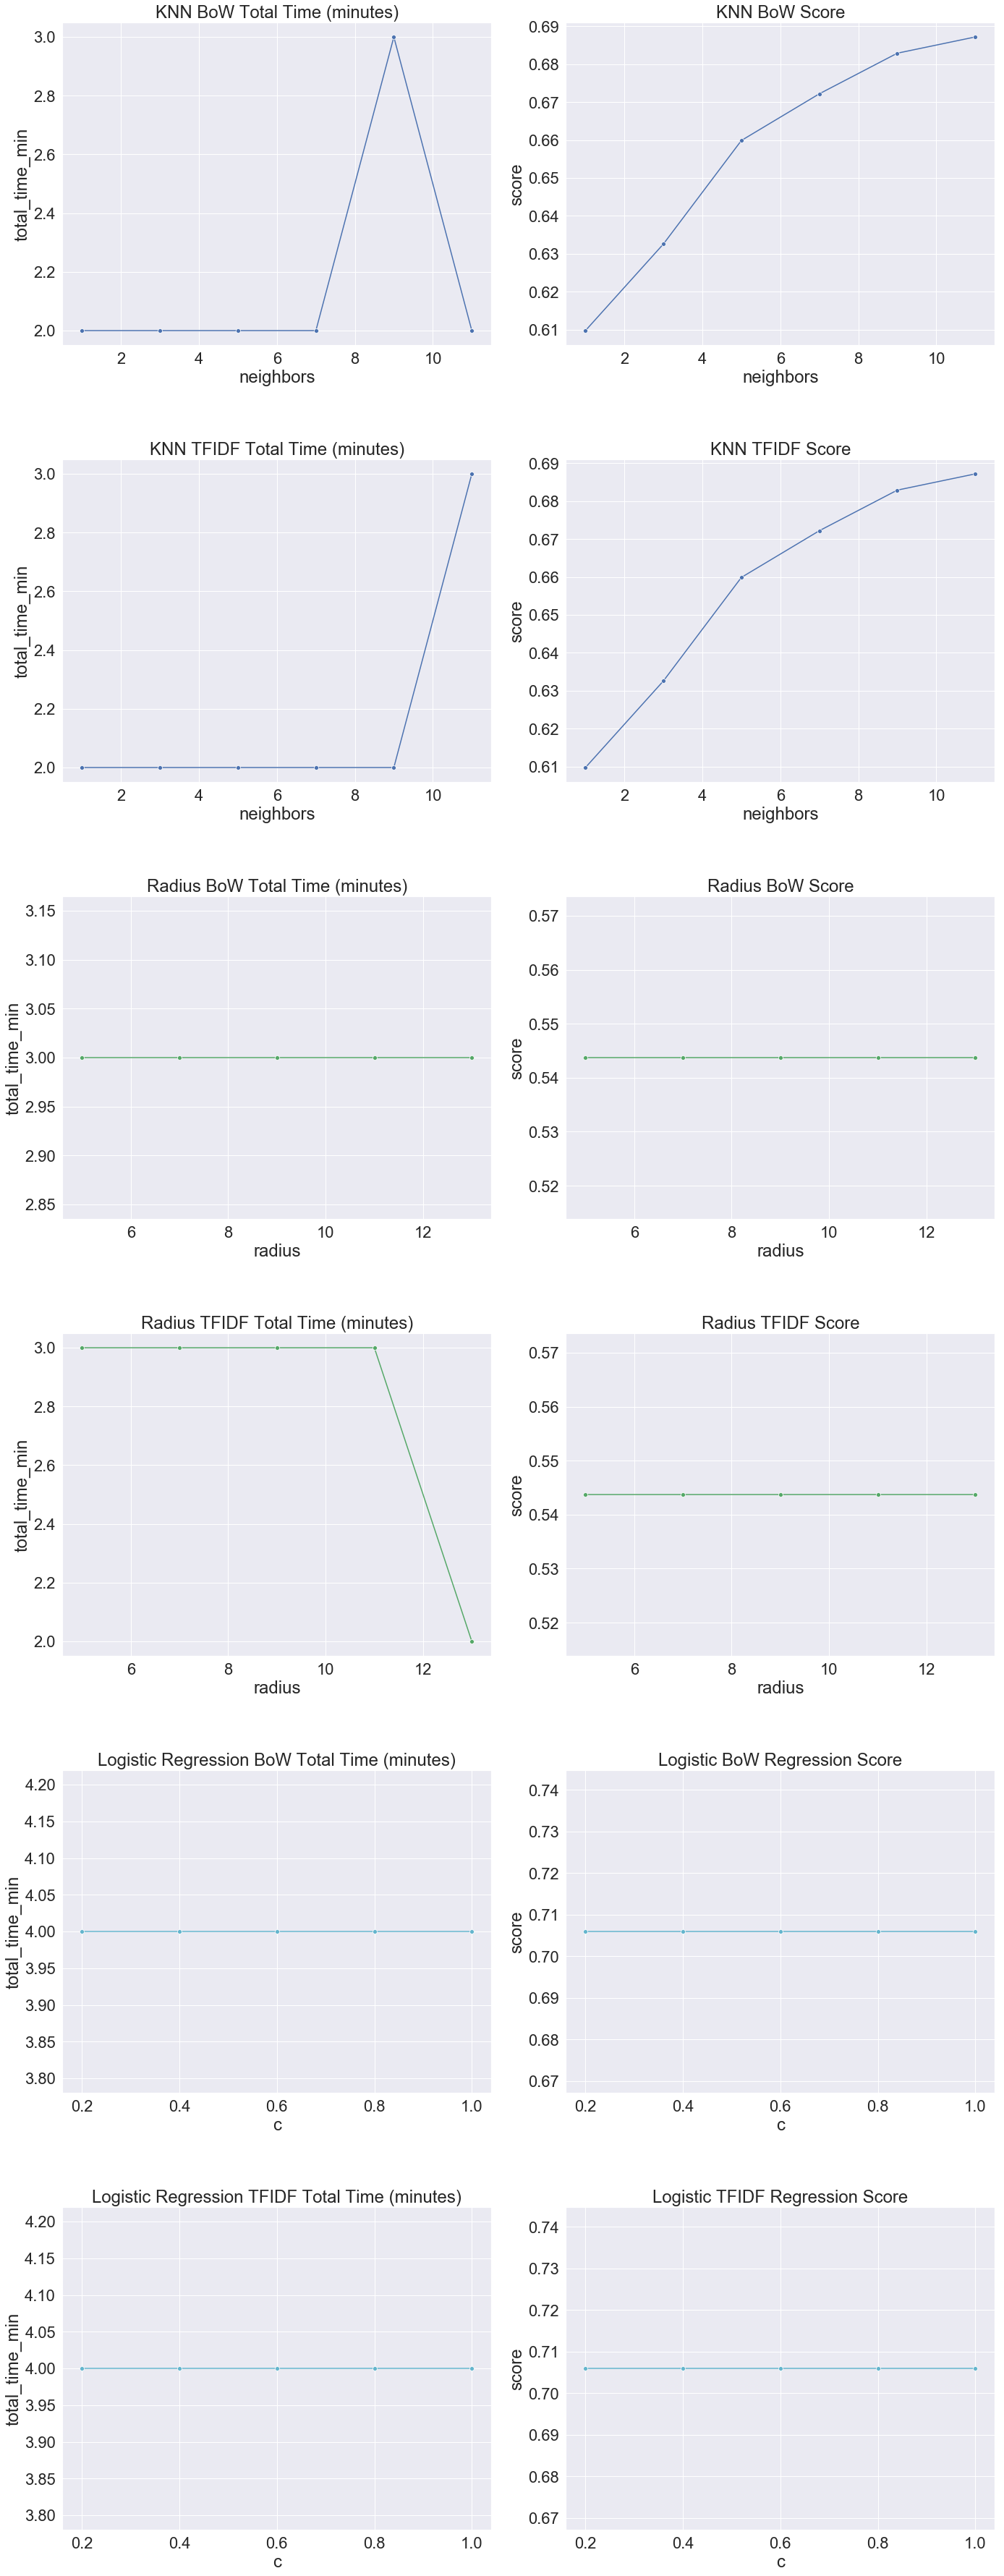

In [19]:
# visualize some data
sns.set(font_scale=2)
sns.set_context(font_scale=3)
f, ax = plt.subplots(6, 2, figsize=(20,50))
plt.tight_layout(pad=2, h_pad=5)

# KNN Graphs

# total time by neighbor
sns.lineplot(x="neighbors", y="total_time_min", data=knn_results_pd, marker='o', color='b', ax=ax[0, 0])
ax[0, 0].set_title("KNN BoW Total Time (minutes)")

# score by neighbor
sns.lineplot(x="neighbors", y="score", data=knn_results_pd, marker='o', color='b', ax=ax[0, 1])
ax[0, 1].set_title("KNN BoW Score")

# total time by neighbor
sns.lineplot(x="neighbors", y="total_time_min", data=knn_tv_results_pd, marker='o', color='b', ax=ax[1, 0])
ax[1, 0].set_title("KNN TFIDF Total Time (minutes)")

# score by neighbor
sns.lineplot(x="neighbors", y="score", data=knn_tv_results_pd, marker='o', color='b', ax=ax[1, 1])
ax[1, 1].set_title("KNN TFIDF Score")


# Radius Neighbor Graphs

# total time by radius
sns.lineplot(x="radius", y="total_time_min", data=rn_results_pd, marker='o', color='g', ax=ax[2, 0])
ax[2, 0].set_title("Radius BoW Total Time (minutes)")

# score by radius
sns.lineplot(x="radius", y="score", data=rn_results_pd, marker='o', color='g', ax=ax[2, 1])
ax[2, 1].set_title("Radius BoW Score")

# total time by radius
sns.lineplot(x="radius", y="total_time_min", data=rn_tv_results_pd, marker='o', color='g', ax=ax[3, 0])
ax[3, 0].set_title("Radius TFIDF Total Time (minutes)")

# score by radius
sns.lineplot(x="radius", y="score", data=rn_tv_results_pd, marker='o', color='g', ax=ax[3, 1])
ax[3, 1].set_title("Radius TFIDF Score")


# Logistic Regression Graphs

# total time by c
sns.lineplot(x="c", y="total_time_min", data=lr_results_pd, marker='o', color='c', ax=ax[4, 0])
ax[4, 0].set_title("Logistic Regression BoW Total Time (minutes)")

# score by c
sns.lineplot(x="c", y="score", data=lr_results_pd, marker='o', color='c', ax=ax[4, 1])
ax[4, 1].set_title("Logistic BoW Regression Score")


# total time by c
sns.lineplot(x="c", y="total_time_min", data=lr_tv_results_pd, marker='o', color='c', ax=ax[5, 0])
ax[5, 0].set_title("Logistic Regression TFIDF Total Time (minutes)")

# score by c
sns.lineplot(x="c", y="score", data=lr_tv_results_pd, marker='o', color='c', ax=ax[5, 1])
ax[5, 1].set_title("Logistic TFIDF Regression Score")

